In [1]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Concatenate, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error

In [2]:
data = []
with open('goodreads_books_poetry.json', 'r', encoding='utf-8') as file:
    for line in file:
        # Parse each line as a JSON object and add it to the list
        try:
            json_data = json.loads(line)
            data.append(json_data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            continue

In [3]:
books = pd.DataFrame(data)
books.head()

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,...,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
0,,1,[],US,eng,"[{'count': '8', 'name': 'to-read'}, {'count': ...",,false,3.83,,...,11,,1887,https://www.goodreads.com/book/show/16037549-v...,https://images.gr-assets.com/books/1348176637m...,16037549,3,5212748,Vision of Sir Launfal and Other Poems,Vision of Sir Launfal and Other Poems
1,0811223981,2,[],US,,"[{'count': '100', 'name': 'to-read'}, {'count'...",,false,3.83,B00U2WY9U8,...,4,,2015,https://www.goodreads.com/book/show/22466716-f...,https://images.gr-assets.com/books/1404958407m...,22466716,37,41905435,Fairy Tales: Dramolettes,Fairy Tales: Dramolettes
2,0374428115,7,[],US,,"[{'count': '32', 'name': 'to-read'}, {'count':...",,false,4.38,,...,7,,2008,https://www.goodreads.com/book/show/926662.Gro...,https://s.gr-assets.com/assets/nophoto/book/11...,926662,45,911665,Growltiger's Last Stand and Other Poems,Growltiger's Last Stand and Other Poems
3,0156182890,12,[],US,,"[{'count': '554', 'name': 'to-read'}, {'count'...",,false,3.71,B00IWTRB1W,...,3,,1964,https://www.goodreads.com/book/show/926667.The...,https://images.gr-assets.com/books/1382939971m...,926667,115,995066,The Cocktail Party,The Cocktail Party
4,1942004192,4,[],US,eng,"[{'count': '228', 'name': 'to-read'}, {'count'...",,false,5.00,,...,12,First,2015,https://www.goodreads.com/book/show/29065952-l...,https://images.gr-assets.com/books/1455198396m...,29065952,9,49294781,Louder Than Everything You Love,Louder Than Everything You Love


In [6]:
num_books = books['book_id'].nunique()
num_works = books['work_id'].nunique()

print(f'Number of unique books: {num_books}')
print(f'Number of unique works: {num_works}')

Number of unique books: 36514
Number of unique works: 25552


In [4]:
# Preprocess book IDs
book_ids = books['book_id'].unique()
book_id_map = {old_id: new_id for new_id, old_id in enumerate(book_ids)}

# Preprocess user IDs
work_ids = books['work_id'].unique()
work_id_map = {old_id: new_id for new_id, old_id in enumerate(work_ids)}


books['work_id'] = books['work_id'].map(work_id_map)
books['book_id'] = books['book_id'].map(book_id_map)

In [7]:
num_books = len(book_ids)
num_work = len(work_ids)

In [8]:
embedding_size = 50
dense_units = 128
dropout_rate=0.0


# Define the model architecture
work_input = Input(shape=(1,))
book_input = Input(shape=(1,))

work_embedding = Embedding(len(work_ids), embedding_size)(work_input)
book_embedding = Embedding(len(book_ids), embedding_size)(book_input)

work_vecs = Flatten()(work_embedding)
book_vecs = Flatten()(book_embedding)

dot_product = Dot(axes=1)([book_vecs, work_vecs])
dense_layer_1 = Dense(dense_units, activation='relu')(dot_product)
dense_layer_2 = Dense(64, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(32, activation='relu')(dense_layer_2)
    
output = Dense(1)(dense_layer_3)
model = Model(inputs=[book_input, work_input], outputs=output)
model.compile(loss='mean_squared_error', optimizer='adam')

In [9]:
X = [books['book_id'], books['work_id']]
y = books['average_rating']
y = y.astype(float)
model.fit(X, y, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
457/457 [==============================] - 12s 25ms/step - loss: 1.7102 - val_loss: 0.1599
Epoch 2/20
457/457 [==============================] - 11s 24ms/step - loss: 0.0876 - val_loss: 0.1629
Epoch 3/20
457/457 [==============================] - 11s 25ms/step - loss: 0.0505 - val_loss: 0.1614
Epoch 4/20
457/457 [==============================] - 11s 25ms/step - loss: 0.0166 - val_loss: 0.1657
Epoch 5/20
457/457 [==============================] - 11s 24ms/step - loss: 0.0102 - val_loss: 0.1640
Epoch 6/20
457/457 [==============================] - 11s 24ms/step - loss: 0.0080 - val_loss: 0.1642
Epoch 7/20
457/457 [==============================] - 11s 25ms/step - loss: 0.0071 - val_loss: 0.1629
Epoch 8/20
457/457 [==============================] - 11s 24ms/step - loss: 0.0060 - val_loss: 0.1642
Epoch 9/20
457/457 [==============================] - 11s 25ms/step - loss: 0.0055 - val_loss: 0.1648
Epoch 10/20
457/457 [==============================] - 11s 25ms/step - loss: 0.005

In [13]:
import numpy as np

# Assuming num_books and num_works are already defined
batch_size = 100 
num_iterations = 10  

book_indices = np.arange(num_books)
work_indices = np.arange(num_works)

book_predictions = []
for i in range(0, num_iterations * batch_size, batch_size):
    batch_work_indices = work_indices[i:i + batch_size]
    batch_predictions = []

    for work_id in batch_work_indices:
        work_array = np.full(num_books, work_id)
        predictions = model.predict([book_indices, work_array])
        batch_predictions.append(predictions)

    book_predictions.extend(batch_predictions)


1142/1142 [==============================] - 2s 2ms/step


In [18]:
reshaped_predictions = transposed_predictions.reshape(36514, 1000)

# Create the DataFrame with proper index and columns
predictions_df = pd.DataFrame(reshaped_predictions, columns=['work_' + str(i) for i in range(1000)])
predictions_df['book_id'] = predictions_df.index


In [25]:
merged_df = pd.merge(books, predictions_df, left_on='book_id', right_on='book_id')
print(merged_df.columns)

Index(['isbn', 'text_reviews_count', 'series', 'country_code', 'language_code',
       'popular_shelves', 'asin', 'is_ebook', 'average_rating', 'kindle_asin',
       ...
       'work_990', 'work_991', 'work_992', 'work_993', 'work_994', 'work_995',
       'work_996', 'work_997', 'work_998', 'work_999'],
      dtype='object', length=1029)


In [31]:
# Sort the merged DataFrame by predicted ratings in descending order and select the top 10 books
top_10_books = merged_df.sort_values(by='average_rating', ascending=False).head(10)

# Print the top 10 recommended books
print("Top 10 Recommended Books:")
print(top_10_books[[ 'title', 'average_rating', 'publication_year']])


Top 10 Recommended Books:
                                   title average_rating publication_year
1516                 The Heart of Autumn           5.00             2011
36149                   tea's aftertaste           5.00             2011
32704                     Hearts Shatter           5.00             2013
9420                   The Female Animal           5.00             2016
20610                  The Empty Quarter           5.00             2010
30582                    Collected Poems           5.00             2016
16658                       Urchin Heart           5.00             2016
24810                     Seeing Lessons           5.00             2010
24811                          ALL OF ME           5.00             2008
1182   Supreme Theater: Political Poetry           5.00             2017


In [33]:
from sklearn.metrics import mean_squared_error 
val_predictions = model.predict(X)
val_mse = mean_squared_error(y, val_predictions)
print("Mean Squared Error (MSE) on validation data: {:.4f}".format(val_mse))
rmse = np.sqrt(val_mse)

print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

1142/1142 [==============================] - 1s 1ms/step
Mean Squared Error (MSE) on validation data: 0.0370
Root Mean Squared Error (RMSE): 0.1923


In [34]:
from sklearn.metrics import roc_auc_score
threshold = 4.5
binary_val_predictions = [1 if rating >= threshold else 0 for rating in val_predictions]
auc_score = roc_auc_score(y > threshold, binary_val_predictions)
print("AUC Score on validation data: {:.4f}".format(auc_score))

AUC Score on validation data: 0.8340


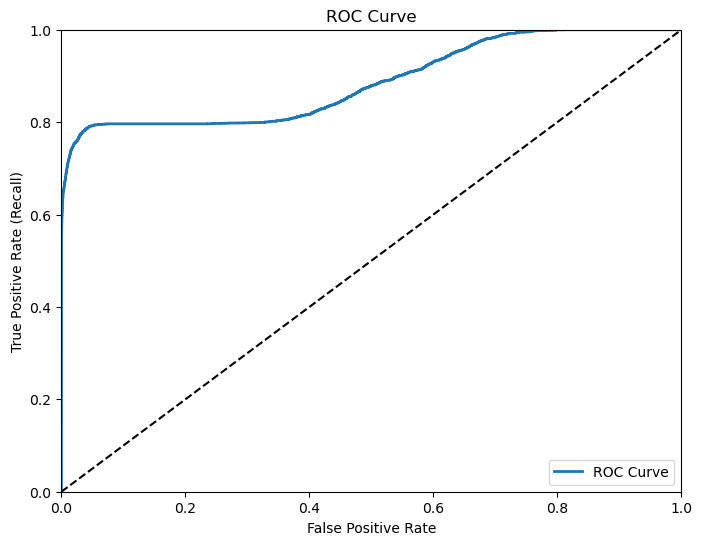

In [40]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, thresholds = roc_curve(y > threshold, val_predictions)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label="ROC Curve")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

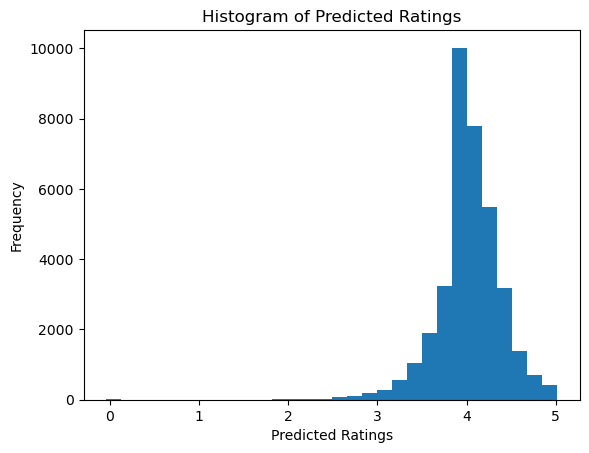

In [41]:
plt.hist(val_predictions, bins=30)
plt.title('Histogram of Predicted Ratings')
plt.xlabel('Predicted Ratings')
plt.ylabel('Frequency')
plt.show()